# **IMPORT LIBS**

In [1]:
import keras
import pandas as pd
import numpy as np
import warnings
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
#from skimage.transform import rotate, shear, zoom
#from imgaug import augmenters as iaa
import tensorflow as tf
import math

import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.models import load_model
from keras.layers import LSTM
from tensorflow.keras.optimizers import Adam

warnings.filterwarnings('ignore')

#**LOAD THE MODEL**

In [ ]:
model = tf.keras.models.load_model('./model_v40.h5')

# (Optional) Print a summary of the model architecture
model.summary()

# **AUX FUNCTIONS**

In [2]:
def save_manovers_positions_to_csv_file(gps_positions, manovers, filename):
  output = np.zeros_like(gps_positions)

  # Iterate through the elements of arr2
  for i in range(len(manovers)):
    # Check if the element in arr2 is 1
    if manovers[i] == 1:
      # Copy the corresponding values from arr1 to the output array
      output[i] = gps_positions[i]

  output = output[~np.all(output == 0, axis=1)]
  np.savetxt(filename, output, delimiter=',', fmt='%.9f')



def separate_positives_negatives(data):
  # Ensure the input is converted to a NumPy array for easier manipulation
  data = np.array(data)

  # Create two empty arrays to store positive and negative values
  positives = np.zeros_like(data)
  negatives = np.zeros_like(data)

  # Use boolean indexing to separate positive and negative values
  positives[data > 0] = data[data > 0]
  negatives[data < 0] = -data[data < 0]

  # Combine the positive and negative values into a single 2D array
  return (positives, negatives)

def normalize_between_0_and_max(data):
  max_value = np.max(data)
  return data / max_value

def normalize_between_0_and_max_v2(data, max_value):
  return data / max_value

def split_train_test(data, test_size=0.2):
  # Check if test_size is between 0 and 1
  if test_size < 0 or test_size > 1:
    raise ValueError("test_size must be between 0 and 1.")

  # Get the number of samples
  num_samples = data.shape[0]

  # Calculate the number of samples for each set
  train_size = int(num_samples * (1 - test_size))
  test_size = num_samples - train_size

  # Randomly shuffle the data for better splitting (optional)
  #np.random.shuffle(data)

  # Split the data into training and test sets
  train_data = data[:train_size]
  test_data = data[train_size:]

  return train_data, test_data

def y_classification(data, threshold):
  classification = np.zeros_like(data, dtype=int)  # Initialize output array

  for col in range(0, 12):  # Loop through each column
    max_value = np.max(data[:, col])
    threshold_pos = max_value * threshold
    classification[:, col] = np.where(data[:, col] >= threshold_pos, 1, 0)

  return classification

def max_of_vectors(vec1, vec2, vec3, vec4, vec5, vec6):
  # Combine all vectors into a single array
  all_vectors = np.array([vec1, vec2, vec3, vec4, vec5, vec6])

  # Find the maximum value in the array
  max_value = np.max(all_vectors)

  return max_value

# **IMPORT DATA**

In [3]:
#df = pd.read_csv('Dataset-viagens-longas.csv')
df = pd.read_csv('Abrantes-Leiria.csv')

acelX = df['accelerometerXAxis']
acelY = df['accelerometerYAxis']
acelZ = df['accelerometerZAxis']

gyrX = df['gyroscopeXAxis']
gyrY = df['gyroscopeYAxis']
gyrZ = df['gyroscopeZAxis']

latitude = df['latitude']
longitude = df['longitude']

In [ ]:
print(df['accelerometerXAxis'].describe())
print(df['accelerometerYAxis'].describe())
print(df['accelerometerZAxis'].describe())
print(df['gyroscopeXAxis'].describe())
print(df['gyroscopeYAxis'].describe())
print(df['gyroscopeZAxis'].describe())

# **SEPARATE DATA BY MANOVER**

In [4]:
turnRightX, turnLeftX = separate_positives_negatives(acelX)

accelY, breakY = separate_positives_negatives(acelY)

positiveZ, negativeZ = separate_positives_negatives(acelZ)

gyrPositiveX, gyrNegativeX = separate_positives_negatives(gyrX)
gyrPositiveY, gyrNegativeY = separate_positives_negatives(gyrY)
gyrPositiveZ, gyrNegativeZ = separate_positives_negatives(gyrZ)

In [ ]:
turnRightX.shape

(35129,)

# **CLASSIFICATION BASED ON NOT NORMALIZED VALUES**

In [5]:
newArray1 = np.array(list(zip(turnRightX, turnLeftX, accelY, breakY, positiveZ, negativeZ, gyrPositiveX, gyrNegativeX, gyrPositiveY, gyrNegativeY, gyrPositiveZ, gyrNegativeZ)))

y = y_classification(newArray1, 0.3)
print (np.sum(y, axis=0))
np.savetxt("Y.csv", y, delimiter=',', fmt='%.0i')

[ 945  836  714  157  259  115  421  687  719  712 1144  375]


# **NORMALIZE DATA**

In [6]:
max_accel = max_of_vectors(turnRightX, turnLeftX, accelY, breakY, positiveZ, negativeZ)
max_gyr = max_of_vectors(gyrPositiveX, gyrNegativeX, gyrPositiveY, gyrNegativeY, gyrPositiveZ, gyrNegativeZ)

In [7]:
turnRightXn = normalize_between_0_and_max_v2(turnRightX, max_accel)
turnLeftXn = normalize_between_0_and_max_v2(turnLeftX, max_accel)
accelYn = normalize_between_0_and_max_v2(accelY, max_accel)
breakYn = normalize_between_0_and_max_v2(breakY, max_accel)
positiveZn = normalize_between_0_and_max_v2(positiveZ, max_accel)
negativeZn = normalize_between_0_and_max_v2(negativeZ, max_accel)
gyrPositiveXn = normalize_between_0_and_max_v2(gyrPositiveX, max_gyr)
gyrNegativeXn = normalize_between_0_and_max_v2(gyrNegativeX, max_gyr)
gyrPositiveYn = normalize_between_0_and_max_v2(gyrPositiveY, max_gyr)
gyrNegativeYn = normalize_between_0_and_max_v2(gyrNegativeY, max_gyr)
gyrPositiveZn = normalize_between_0_and_max_v2(gyrPositiveZ, max_gyr)
gyrNegativeZn = normalize_between_0_and_max_v2(gyrNegativeZ, max_gyr)

# **CREATE AN ARRAY WITH ALL DATA**

In [8]:
newArray = np.array(list(zip(turnRightXn, turnLeftXn, accelYn, breakYn, positiveZn, negativeZn, gyrPositiveXn, gyrNegativeXn, gyrPositiveYn, gyrNegativeYn, gyrPositiveZn, gyrNegativeZn)))

In [ ]:
newArray.shape

(35129, 12)

In [ ]:
#y1 = y_classification(newArray, 0.3)
#print (np.sum(y1, axis=0))
#np.savetxt("Y.csv", y1, delimiter=',', fmt='%.0i')

[ 945  836  714  157  259  115  421  687  719  712 1144  375]


# **SHOW MANOVERS ON GOOLGE MAP**

In [ ]:
positions = np.array(list(zip(latitude, longitude)))
manover_accelY = y[:, 2]
manover_breakY = y[:, 3]
manover_turnRightXn = y[:, 0]
manover_turnLeftXn = y[:, 1]
gyrPositiveZn = y[:, 10]
gyrNegativeZn = y[:, 11]
save_manovers_positions_to_csv_file(positions, manover_accelY, "accelY.csv")
save_manovers_positions_to_csv_file(positions, manover_breakY, "breakY.csv")
save_manovers_positions_to_csv_file(positions, manover_turnRightXn, "turnRightX.csv")
save_manovers_positions_to_csv_file(positions, manover_turnLeftXn, "turnLeftX.csv")
save_manovers_positions_to_csv_file(positions, gyrPositiveZn, "gyrPositZ.csv")
save_manovers_positions_to_csv_file(positions, gyrNegativeZn, "gyrNegZ.csv")

# **PLOT MANOVERS**

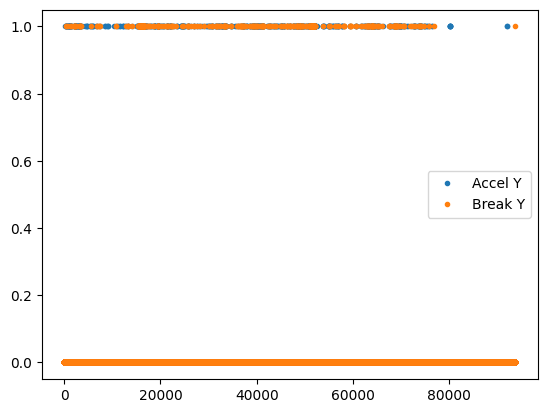

In [ ]:
plt.plot(y[:, 2], marker='.', linestyle='none')
plt.plot(y[:, 3], marker='.', linestyle='none')

plt.legend(['Accel Y', 'Break Y'])
plt.show()

# **SEPARATE DATA IN TRAIN AND TEST**

In [9]:
x_treino, x_teste = split_train_test(newArray, test_size=0.2)

y_treino, y_teste = split_train_test(y, test_size=0.2)

# **CREATE THE INPUT TENSORES DATA**

In [10]:
treino = x_treino.reshape(x_treino.shape[0], 1, x_treino.shape[1])
teste = x_teste.reshape(x_teste.shape[0], 1, x_teste.shape[1])

# **CREATE THE MODEL**

In [21]:
K.clear_session()

model = Sequential()
model.add(Dense(128, input_shape=(1, treino.shape[2]), activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='linear'))
model.add(Dense(y_treino.shape[1], activation='sigmoid'))

# **COMPILE THE MODEL**

In [22]:
model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)

# **TRAIN THE MODEL**

In [ ]:
model_output = model.fit(treino, y_treino, epochs=10, batch_size=4, verbose=1, shuffle=False, callbacks=[early_stop], validation_data=(teste, y_teste))

# **SHOW THE RESULTS**

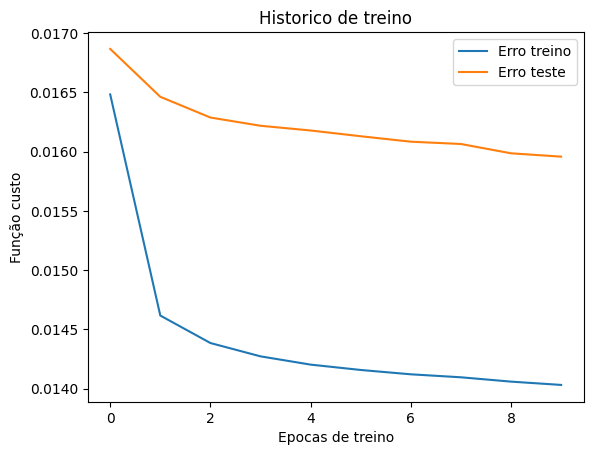

In [24]:
plt.plot(model_output.history['loss'])
plt.plot(model_output.history['val_loss'])
plt.title('Historico de treino')
plt.xlabel('Epocas de treino')
plt.ylabel('Função custo')
plt.legend(['Erro treino', 'Erro teste'])
plt.show()

In [ ]:
#accuracy = model_lstm.evaluate(teste, y_teste)[1]  # Assuming accuracy is the second metric
#print('Test Accuracy:', accuracy)

# **TEST THE NETWORK**

In [ ]:
loss = model.evaluate(teste, y_teste, batch_size=1)
print('Test loss:', loss)


In [ ]:
teste[0]

array([0.08609113, 0.        , 0.00198503, 0.        , 0.        ,
       0.12521949, 0.        , 0.07666345, 0.22034716, 0.        ,
       0.        , 0.02507232])

In [ ]:
teste.shape

(1, 12)

In [ ]:
i = 0
for i in range(100):
    a = x_teste[i]
    b = a.reshape(1, 1, 12)

    # Make predictions on new data
    prediction = model.predict(b)
    #predicted_class = label_encoder.inverse_transform(prediction)[0]

    np.round(prediction, decimals=1, out=prediction)
    np.round(x_teste[i], decimals=1, out=x_teste[i])
    #print("Value:", newArray[i + start])
    if (np.sum(y_teste[i]) > 0):
      print("X [:", x_teste[i])
      print("Y [:", y_teste[i])
      print("PC:", prediction)
      print (i)
    i = 1 + 1
#PREDICTIONS WITH COLAB MODEL
#prediction = model.predict(teste)
#print("Predicted class:", prediction)
#print("Predicted class:", predicted_class)

In [ ]:
teste_value = np.array([0., 0.363, 0.313, 0., 0., 0.31, 0.393, 0., 0., 0.244, 0.247, 0.])
teste_value = teste_value.reshape(1, 1, 12)

# Make predictions on new data
prediction = model.predict(teste_value)
np.round(prediction, decimals=2, out=prediction)

print("Value    :", teste_value[0][0])
print("Predicted:", prediction[0])


# **SAVE THE MODEL**

In [ ]:
import os
model.save(os.path.join(".", 'model_v40.h5'))